In [2]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import LorentzianModel, GaussianModel, SplineModel, VoigtModel

In [4]:
#loading 6 peaks
folder_path = 'spectroscopy_data/peaks_6'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
dataframes6peaks = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes6peaks.append(df)
    print(f"{i} Loaded {file}:")

1 Loaded spectroscopy_data/peaks_6\6_ (1).CSV:
2 Loaded spectroscopy_data/peaks_6\6_ (10).CSV:
3 Loaded spectroscopy_data/peaks_6\6_ (2).CSV:
4 Loaded spectroscopy_data/peaks_6\6_ (3).CSV:
5 Loaded spectroscopy_data/peaks_6\6_ (4).CSV:
6 Loaded spectroscopy_data/peaks_6\6_ (5).CSV:
7 Loaded spectroscopy_data/peaks_6\6_ (6).CSV:
8 Loaded spectroscopy_data/peaks_6\6_ (7).CSV:
9 Loaded spectroscopy_data/peaks_6\6_ (8).CSV:
10 Loaded spectroscopy_data/peaks_6\6_ (9).CSV:
11 Loaded spectroscopy_data/peaks_6\CS-BB-22.CSV:
12 Loaded spectroscopy_data/peaks_6\CS-BB-23.CSV:


In [5]:
y = dataframes6peaks[4]['CH1[V]'] * 100
x = dataframes6peaks[4]['[s]'] * 1000

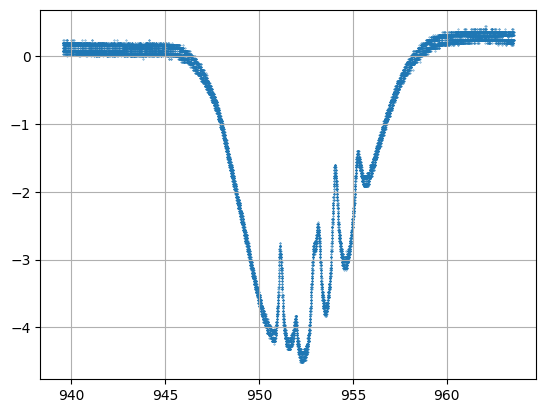

In [6]:
plt.scatter(x,y, s=0.1)
# plt.ylim(0,0.5)
# plt.xlim(960, 961)
plt.grid()

In [7]:
#function for moving average over 10 pts on the second axis

def move_ave(arr, window_size=10):
    window_size = 10

    numbers_series = pd.Series(arr)
    
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)
    
    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()
    
    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    
    # Remove null entries from the list
    final_list = moving_averages_list[window_size - 1:]
    return final_list


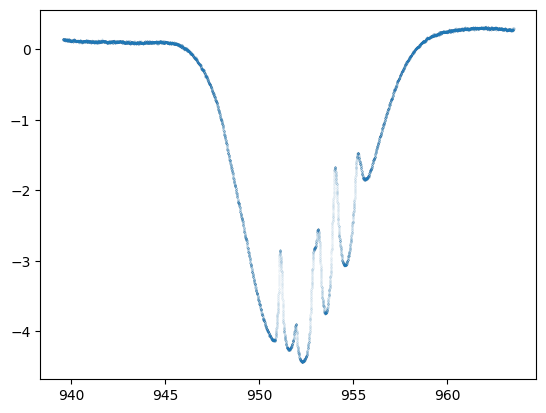

In [8]:
#getting&plotting moving averaged data
x_aveg = np.array(move_ave(x))
y_aveg = np.array(move_ave(y))
plt.scatter(x_aveg, y_aveg, s=0.001)

In [9]:
#defining knot making function
def get_knots(npoints = 10 , dataset=None, x=None, y=None, plotting = False):
    '''
        gets the knots positions at local minima in constants steps
        if plotting True : returns tuple xknots, yknots
    '''
    if dataset != None:
        x = dataset['[s]']
        y = dataset['CH1[V]']
    step = int(len(x)/npoints)
    knots = np.zeros(npoints, dtype=int)
    cutleft = 0
    cutright = step
    for n in range(npoints):
        localmin = y[cutleft:cutright].argmin()
        index_localmin = int(cutleft + localmin)
        knots[n] = index_localmin
        cutleft += step
        cutright += step
    if plotting:
        print('the knots are at second indices:', knots)
        print('the knots are at yvals:', y[knots])
        return (knots, y[knots])
    else:
        print('the knots are at seconds indices:', knots)
        return knots


In [10]:
#getting knots
xknots_indices, yknots = get_knots(x=x_aveg, y=y_aveg,  npoints = 20, plotting=True)

the knots are at second indices: [  723  1261  2984  3396  4692  5978  6989  7991  8990  9982 10608 11642
 12462 13404 13986 14994 16003 17044 17991 19674]
the knots are at yvals: [ 0.096  0.092  0.076  0.072  0.072 -0.2   -0.976 -2.476 -3.924 -4.244
 -4.44  -3.748 -3.068 -1.856 -1.328 -0.36   0.1    0.236  0.276  0.256]


(950.0, 957.0)

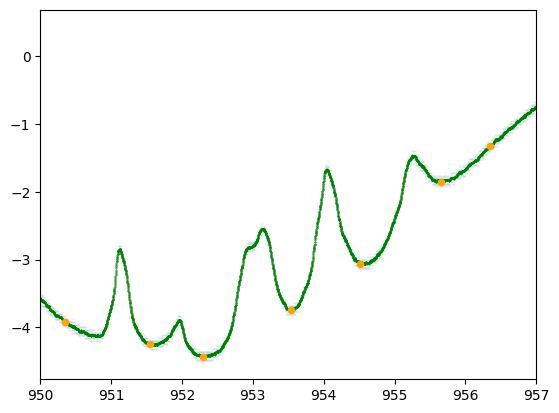

In [11]:
#plotting knots
plt.scatter(x,y, s=0.1, alpha=0.05)
plt.scatter(x_aveg,y_aveg, s=0.1, color= 'green')
plt.scatter(x_aveg[xknots_indices], yknots, s=20, color ='orange')
plt.xlim(950, 957)

In [12]:
#gauss model for bk
gauss = GaussianModel(prefix='gauss_')
params = gauss.guess(y_aveg, x_aveg)

In [13]:
model = gauss
out = model.fit(y_aveg, params, x=x_aveg)
print(out.fit_report(min_correl=0.3))
comps = out.eval_components()

[[Model]]
    Model(gaussian, prefix='gauss_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 19991
    # variables        = 3
    chi-square         = 2179.56497
    reduced chi-square = 0.10904367
    Akaike info crit   = -44297.1920
    Bayesian info crit = -44273.4829
    R-squared          = 0.95396759
[[Variables]]
    gauss_amplitude: -26.7245487 +/- 0.04219618 (0.16%) (init = 171.4182)
    gauss_center:     951.944273 +/- 0.00466553 (0.00%) (init = 951.4451)
    gauss_sigma:      2.55901146 +/- 0.00466559 (0.18%) (init = 11.994)
    gauss_fwhm:       6.02601137 +/- 0.01098662 (0.18%) == '2.3548200*gauss_sigma'
    gauss_height:    -4.16627792 +/- 0.00657826 (0.16%) == '0.3989423*gauss_amplitude/max(1e-15, gauss_sigma)'
[[Correlations]] (unreported correlations are < 0.300)
    C(gauss_amplitude, gauss_sigma) = -0.5774


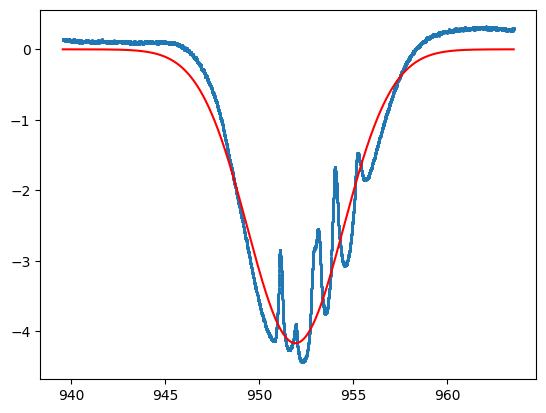

In [14]:
plt.scatter(x_aveg, y_aveg, s=1)
plt.plot(x_aveg, out.best_fit, label='best fit', color= 'red')

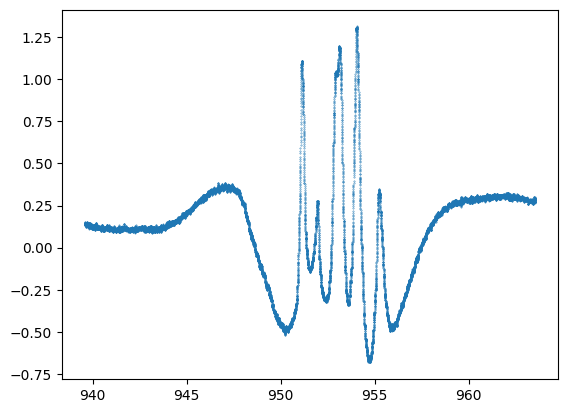

In [15]:
ysubtract_gauss = y_aveg - comps['gauss_']
plt.scatter(x_aveg, ysubtract_gauss, s = 0.1)

In [16]:
#spline model
bkg = SplineModel(prefix='bkg_', xknots=x_aveg[xknots_indices])
params = bkg.guess(y_aveg  , x_aveg)
params

name,value,initial value,min,max,vary
bkg_s0,0.09733333,None,-inf,inf,True
bkg_s1,0.09266667,None,-inf,inf,True
bkg_s2,0.07666667,None,-inf,inf,True
bkg_s3,0.07266667,None,-inf,inf,True
bkg_s4,0.07266667,None,-inf,inf,True
bkg_s5,-0.19933333,None,-inf,inf,True
bkg_s6,-0.97466667,None,-inf,inf,True
bkg_s7,-2.47600000,None,-inf,inf,True
bkg_s8,-3.92333333,None,-inf,inf,True
bkg_s9,-4.24333333,None,-inf,inf,True


In [17]:
for key in params.keys():
    print(params[key])
    params[key].min = params[key].value - 0.2
    params[key].max = params[key].value + 0.2
params

<Parameter 'bkg_s0', value=0.09733333333333333, bounds=[-inf:inf]>
<Parameter 'bkg_s1', value=0.09266666666666666, bounds=[-inf:inf]>
<Parameter 'bkg_s2', value=0.07666666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s3', value=0.07266666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s4', value=0.07266666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s5', value=-0.19933333333333333, bounds=[-inf:inf]>
<Parameter 'bkg_s6', value=-0.9746666666666667, bounds=[-inf:inf]>
<Parameter 'bkg_s7', value=-2.476, bounds=[-inf:inf]>
<Parameter 'bkg_s8', value=-3.9233333333333333, bounds=[-inf:inf]>
<Parameter 'bkg_s9', value=-4.243333333333333, bounds=[-inf:inf]>
<Parameter 'bkg_s10', value=-4.439333333333334, bounds=[-inf:inf]>
<Parameter 'bkg_s11', value=-3.7473333333333336, bounds=[-inf:inf]>
<Parameter 'bkg_s12', value=-3.0660000000000003, bounds=[-inf:inf]>
<Parameter 'bkg_s13', value=-1.8553333333333335, bounds=[-inf:inf]>
<Parameter 'bkg_s14', value=-1.3273333333333335, bounds=[-inf:inf]>
<Par

name,value,initial value,min,max,vary
bkg_s0,0.09733333,None,-0.10266667,0.29733333,True
bkg_s1,0.09266667,None,-0.10733333,0.29266667,True
bkg_s2,0.07666667,None,-0.12333333,0.27666667,True
bkg_s3,0.07266667,None,-0.12733333,0.27266667,True
bkg_s4,0.07266667,None,-0.12733333,0.27266667,True
bkg_s5,-0.19933333,None,-0.39933333,6.6667e-04,True
bkg_s6,-0.97466667,None,-1.17466667,-0.77466667,True
bkg_s7,-2.47600000,None,-2.67600000,-2.27600000,True
bkg_s8,-3.92333333,None,-4.12333333,-3.72333333,True
bkg_s9,-4.24333333,None,-4.44333333,-4.04333333,True


In [18]:
#peaks
# peak1 = LorentzianModel(prefix='l1_')
# params.update(peak1.make_params(center=dict(value=947.2, min=947, max=947.5),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak2 = LorentzianModel(prefix='l2_')
# params.update(peak2.make_params(center=dict(value=948, min=947.5, max=948.5),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak3 = LorentzianModel(prefix='l3_')
# params.update(peak3.make_params(center=dict(value=949, min=948.5, max=949.6),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))
# peak4 = LorentzianModel(prefix='l4_')
# params.update(peak4.make_params(center=dict(value=950.1, min=949.5, max=950.6),
#                                sigma=dict(value=0.1, min=0),
#                                amplitude=dict(value=1, min=0)))

In [19]:
# model =   bkg + peak1 +peak2 + peak3 
model =   bkg
# model = gauss

init = model.eval(params, x=x_aveg) #for evaling initial guess
out = model.fit(y_aveg, params, x=x_aveg) 
print(out.fit_report(min_correl=0.3))

[[Model]]
    Model(spline_model, prefix='bkg_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 19991
    # variables        = 20
    chi-square         = 1722.25406
    reduced chi-square = 0.08623775
    Akaike info crit   = -48970.8999
    Bayesian info crit = -48812.8392
    R-squared          = 0.96362600
##  Warning: uncertainties could not be estimated:
    bkg_s0:   at initial value
    bkg_s1:   at initial value
    bkg_s2:   at initial value
    bkg_s3:   at initial value
    bkg_s4:   at initial value
    bkg_s5:   at initial value
    bkg_s6:   at initial value
    bkg_s7:   at initial value
    bkg_s8:   at initial value
    bkg_s9:   at initial value
    bkg_s10:  at initial value
    bkg_s11:  at initial value
    bkg_s12:  at initial value
    bkg_s13:  at initial value
    bkg_s14:  at initial value
    bkg_s15:  at initial value
    bkg_s16:  at initial value
    bkg_s17:  at initial value
    bkg_s18:  at init

In [20]:
knot_yvals = np.array([o.value for o in out.params.values() if o.name.startswith('bkg')])

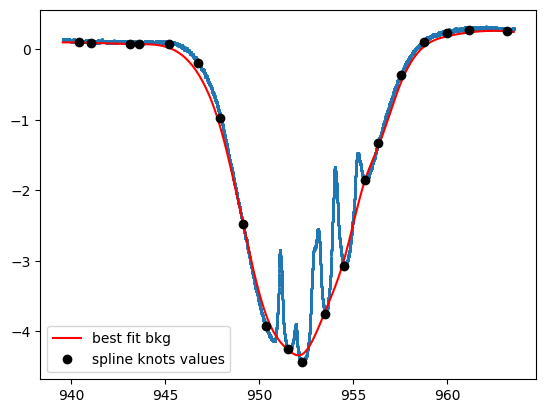

In [21]:
#get the component vals
comps = out.eval_components()

#og data
plt.scatter(x_aveg, y_aveg, s=1)
#best fit
plt.plot(x_aveg, out.best_fit, label='best fit bkg', color= 'red')
#background
# plt.plot(x_aveg, comps['bkg_'], label='background')
#gauss
# plt.plot(x_aveg, comps['gauss_'], label = 'gauss')
#splines
plt.plot(x_aveg[xknots_indices], knot_yvals, 'o', color='black', label='spline knots values')


# plt.plot(x, comps['l1_'], label='peak')
# plt.plot(x, comps['l2_'], label='peak')
# plt.plot(x, comps['l3_'], label='peak')
# plt.plot(x, comps['l4_'], label='peak')

plt.legend()



### evaluating peaks

In [22]:
ynew = y_aveg - comps['bkg_']
ynew *= 100

literally same shit


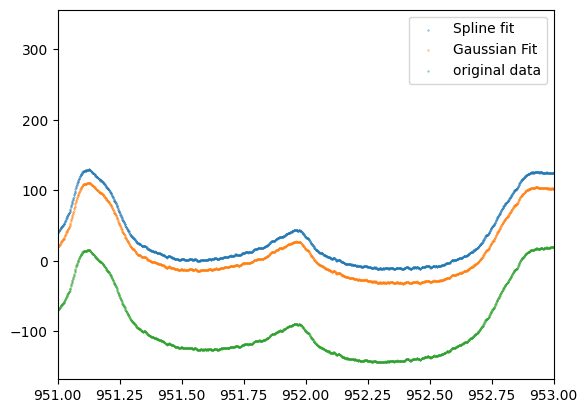

In [32]:
# plt.scatter(x,y,s=0.1)
# plt.plot(x, comps['bkg_'], label='background')
plt.scatter(x_aveg, ynew, s = 0.1, label = 'Spline fit')
plt.scatter(x_aveg, ysubtract_gauss*100, s = 0.1, label = 'Gaussian Fit')
plt.scatter(x_aveg, y_aveg*100+300, s=0.1, label = 'original data')
plt.legend()
plt.xlim(951, 953)
print('literally same shit')


### honestly, Looks like either Gauss or even the complicated Spline fit have more or less same peaks - let's see after eval

In [24]:
l1 = LorentzianModel(prefix='l1_')

params = l1.make_params(
    center = 951, 
    sigma = 0.4,
    amplitude = 120
)

l2 = LorentzianModel(prefix='l2_')
params = params.update(l2.make_params(
    center = dict(value = 952, max = 952.1, min = 951.8),
    sigma= dict(value = 0.2, max=0.4),
    amplitude = 10
))

l3a = LorentzianModel(prefix='l3a_')
params = params.update(l3a.make_params(
    center = dict(value=953),
    sigma = 0.3,
    amplitude =  100
))
l3b = LorentzianModel(prefix='l3b_')
params = params.update(l3b.make_params(
    center = dict(value=953),
    sigma = 0.3,
    amplitude =  100
))

l4 = LorentzianModel(prefix='l4_')
params = params.update(l4.make_params(
    center = dict(value =954),
    sigma = 0.5,
    amplitude = 120
))

l5 = LorentzianModel(prefix='l5_')
params = params.update(l5.make_params(
    center = dict(value =955.5),
    sigma = 0.5,
    amplitude = 50
))

In [25]:
model  = l1 + l3a + l3b +l4 +l5 +l2

init = model.eval(params, x=x_aveg)
out = model.fit(ynew, params, x=x_aveg)
print(out.fit_report(min_correl=0.3))


[[Model]]
    (((((Model(lorentzian, prefix='l1_') + Model(lorentzian, prefix='l3a_')) + Model(lorentzian, prefix='l3b_')) + Model(lorentzian, prefix='l4_')) + Model(lorentzian, prefix='l5_')) + Model(lorentzian, prefix='l2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 341
    # data points      = 19991
    # variables        = 18
    chi-square         = 2069134.29
    reduced chi-square = 103.596570
    Akaike info crit   = 92786.3118
    Bayesian info crit = 92928.5665
    R-squared          = 0.85774542
[[Variables]]
    l1_amplitude:   36.2111690 +/- 0.36193530 (1.00%) (init = 120)
    l1_center:      951.141756 +/- 8.2517e-04 (0.00%) (init = 951)
    l1_sigma:       0.08266552 +/- 0.00117012 (1.42%) (init = 0.4)
    l1_fwhm:        0.16533103 +/- 0.00234024 (1.42%) == '2.0000000*l1_sigma'
    l1_height:      139.433877 +/- 1.38953026 (1.00%) == '0.3183099*l1_amplitude/max(1e-15, l1_sigma)'
    l2_amplitude:   7.57496629 +/- 0.29647697 (3.91%) (i

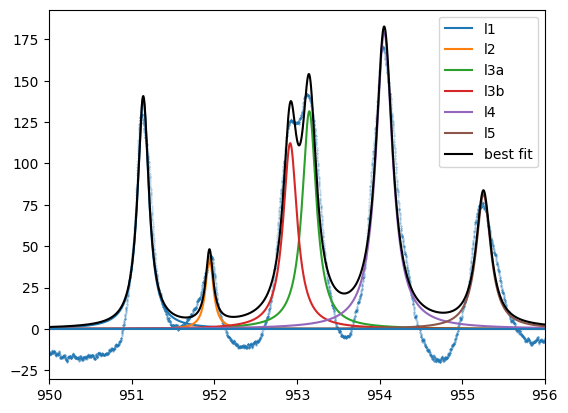

In [26]:

comps = out.eval_components()
plt.plot(x_aveg, comps['l1_'], label='l1')
plt.plot(x_aveg, comps['l2_'], label='l2')
plt.plot(x_aveg, comps['l3a_'], label='l3a')
plt.plot(x_aveg, comps['l3b_'], label='l3b')
plt.plot(x_aveg, comps['l4_'], label='l4')
plt.plot(x_aveg, comps['l5_'], label='l5')
# plt.plot()
plt.plot(x_aveg, out.best_fit, label='best fit', color= 'black', alpha = 1)
plt.scatter(x_aveg,ynew,s=0.1, alpha = 0.5)
plt.axhline(0)
plt.xlim(950,956)
plt.legend()

In [27]:
out

### result centers

In [44]:
rate = 78139901249.54921
rate *= 1e-9
alt2_rate = 88.35292429930405


In [34]:
result_peaks = np.zeros(6)
i = 0
for name, param in out.params.items():
    if 'center' in name:
        print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')
        result_peaks[i] = param.value
        i+=1 
print(result_peaks)

l1_center   951.14176     0.00083
l2_center   951.94300     0.00213
l3a_center   953.15095     0.00136
l3b_center   952.91971     0.00155
l4_center   954.05664     0.00078
l5_center   955.25735     0.00161
[951.1417562  951.94300291 953.1509522  952.91971221 954.05663726
 955.25734996]


In [51]:
#expected transitions in giga
transitionsf3 = [0, 151.21, 352.45000000000005] + [ 75.605 ,251.83 , 176.225]
transitionsf3 = np.sort(transitionsf3)
transitionsf4 = [0, 201.24, 452.24] + [100.62 ,326.74 ,226.12]

<BarContainer object of 6 artists>

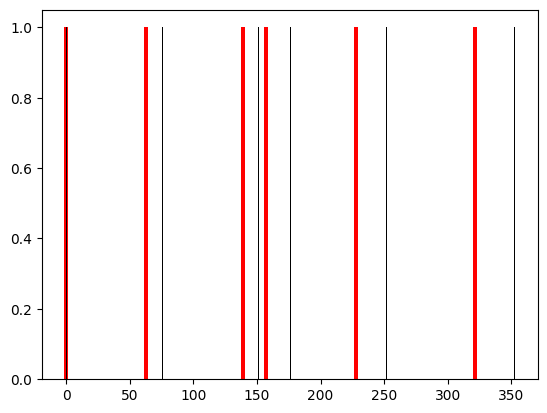

In [52]:
#fitting for f3
result_peaks -= result_peaks[0]
plt.bar(result_peaks*rate, height=np.ones(6), width=3, color = 'red')
# plt.bar(result_peaks*alt2_rate, height=np.ones(6), width=3, color = 'red')
plt.bar(transitionsf3, height=np.ones(6), width=1, color = 'black', linestyle ='-')